In [14]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import os

In [15]:
class ConvLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, conv_channels, conv_kernel_sizes):
        super(ConvLSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.softmax = nn.Softmax()
        
        # # Define 1D convolutional layers
        # self.conv_layers = nn.ModuleList()
        # for i, (out_channels, kernel_size) in enumerate(zip(conv_channels, conv_kernel_sizes)):
        #     if i == 0:
        #         self.conv_layers.append(nn.Conv1d(input_size, out_channels, kernel_size, bias=False))
        #     else:
        #         self.conv_layers.append(nn.Conv1d(conv_channels[i-1], out_channels, kernel_size, bias=False))
        
        # Define LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        # Define fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        # Apply 1D convolutional layers
        # for conv_layer in self.conv_layers:
        #     x = conv_layer(x)
        #     x = nn.functional.relu(x)
        
        # Permute tensor to match LSTM input shape
        x = x.permute(0, 2, 1)
        
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])

        # Apply Softmax Function to get vector of probabilities
        out = self.softmax(out)
        return out

In [64]:
"""
This class is taken from the Python Library Arithmetic Encoding: https://github.com/ahmedfgad/ArithmeticEncodingPython. 
I have made some changes to fit my purpose. 
"""

from decimal import Decimal

class ArithmeticEncoding:
    """
    ArithmeticEncoding is a class for building arithmetic encoding.
    """

    def __init__(self, frequency_table):
        self.probability_table = self.get_probability_table(frequency_table)

    def get_probability_table(self, frequency_table):
        """
        Calculates the probability table out of the frequency table.
        """
        total_frequency = sum(list(frequency_table.values()))

        probability_table = {}
        for key, value in frequency_table.items():
            probability_table[key] = value/total_frequency

        return probability_table

    def get_encoded_value(self, encoder):
        """
        After encoding the entire message, this method returns the single value that represents the entire message.
        """
        last_stage = list(encoder[-1].values())
        last_stage_values = []
        for sublist in last_stage:
            for element in sublist:
                last_stage_values.append(element)

        last_stage_min = min(last_stage_values)
        last_stage_max = max(last_stage_values)

        return (last_stage_min + last_stage_max)/2

    def process_stage(self, probability_table, stage_min, stage_max):
        """
        Processing a stage in the encoding/decoding process.
        """
        stage_probs = {}
        stage_domain = stage_max - stage_min
        for term_idx in range(len(probability_table.items())):
            term = list(probability_table.keys())[term_idx]
            term_prob = Decimal(probability_table[term])
            cum_prob = term_prob * stage_domain + stage_min
            stage_probs[term] = [stage_min, cum_prob]
            stage_min = cum_prob
        return stage_probs

    def encode(self, msg, probability_table):
        """
        Encodes a message.
        """

        encoder = []

        stage_min = Decimal(0.0)
        stage_max = Decimal(1.0)

        for msg_term_idx in range(len(msg)):
            stage_probs = self.process_stage(probability_table, stage_min, stage_max)

            msg_term = msg[msg_term_idx]
            stage_min = stage_probs[msg_term][0]
            stage_max = stage_probs[msg_term][1]

            encoder.append(stage_probs)

        stage_probs = self.process_stage(probability_table, stage_min, stage_max)
        encoder.append(stage_probs)

        encoded_msg = self.get_encoded_value(encoder)

        return encoder, encoded_msg

    def decode(self, encoded_msg, msg_length, probability_table):
        """
        Decodes a message.
        """

        decoder = []
        decoded_msg = ""

        stage_min = Decimal(0.0)
        stage_max = Decimal(1.0)

        for idx in range(msg_length):
            stage_probs = self.process_stage(probability_table, stage_min, stage_max)

            for msg_term, value in stage_probs.items():
                if encoded_msg >= value[0] and encoded_msg <= value[1]:
                    break

            decoded_msg = decoded_msg + msg_term
            stage_min = stage_probs[msg_term][0]
            stage_max = stage_probs[msg_term][1]

            decoder.append(stage_probs)

        stage_probs = self.process_stage(probability_table, stage_min, stage_max)
        decoder.append(stage_probs)

        return decoder, decoded_msg

In [147]:
def midi_to_note_name(midi_note):
    """
    Convert MIDI note number to note name.
    """
    notes = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    octave = (midi_note // 12) - 1
    note_index = midi_note % 12
    note_name = notes[note_index]
    return f"{note_name}{octave}"

def loadData(musicId):
    dataDir = "../music_data/"
    metadata = pd.read_csv(os.path.join(dataDir, "musicnet_metadata.csv"))
    df = pd.read_csv(f'musicnet/train_labels/{musicId}.csv')
    return metadata, df

def create_dataset(dataset, output_categories, length):
    X, y = [], []
    for i in range(len(dataset) - length):
        feature = dataset[i:i+length]
        target = np.where(output_categories == dataset[i+1:i+length+1])[1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.eye(len(output_categories))[y]

def generateFrequencyTableEncoder(data):
    data = np.squeeze(data)
    frequencyTable = {}
    for idx in range(len(data)):
        if data[idx] in list(frequencyTable.keys()):
            frequencyTable[data[idx]] += 1
        else:
            frequencyTable[data[idx]] = 1
    return frequencyTable

def generateFrequencyTableDecoder(data):
    data = np.squeeze(data)
    frequencyTable = {}
    for idx in range(len(data)):
        if str(data[idx]) in list(frequencyTable.keys()):
            frequencyTable[str(data[idx])] += 1
        else:
            frequencyTable[str(data[idx])] = 1
    return frequencyTable

def formatDecodedOutput(data):
    nums = data.split(".")
    nums = [int(num) for num in nums]
    return nums[:-1]
    

In [240]:
## Compression
seq_len = 7
musicId = 2659
modelName = "models/100h,3layer.pt"
rate = 16

# Load the Data
metadata, musicData = loadData(musicId)
outputCategories = musicData['note'].unique()
music_ts = np.zeros((musicData['start_beat'].size, 1)) # Time series of song 
for i in range(musicData['start_beat'].size):
    music_ts[i:i + int(np.ceil(musicData['end_beat'][i])), :] = int(musicData['note'][i])
    
    
model_data = torch.ones((1, seq_len, 1)) * music_ts[0:seq_len, :]
model_data = model_data.to(torch.float32)

# Load the LSTM Model
device = torch.device("cuda")
model = torch.load(modelName)

# Pass in the data iteratively and get the arithmetic encoding

with torch.no_grad():
    aeCodes = []
    comSeq = np.ones((seq_len+1))
    comSeq[:seq_len] = np.squeeze(model_data)
    for i in range(1, len(music_ts) - seq_len):
        
        # Get the 8th Note to form a 2-measure sequence
        comSeq[-1] = outputCategories[np.argmax(model(model_data))]
        
        # Get Frequency Table
        frequencyTable = generateFrequencyTableEncoder(comSeq)
        
        # Generate Arithmetic Code
        arithmeticCode = ArithmeticEncoding(frequency_table=frequencyTable)
        aeCodes.append(arithmeticCode.encode(msg=np.squeeze(comSeq), probability_table=arithmeticCode.probability_table)[1])
        
        # Shift Input Array
        comSeq = np.roll(comSeq, -1, axis=0)
        
        if i % rate == 0:
            model_data = torch.from_numpy(music_ts[i:i+seq_len]).unsqueeze(0).to(torch.float32)
            comSeq[:seq_len] = np.squeeze(music_ts[i:i+seq_len])
        else:
            model_data = torch.from_numpy(comSeq[1:]).unsqueeze(0).unsqueeze(2).to(torch.float32)
        
print(f"Arithemtic Codes from First 5 out of {len(aeCodes)} Total Codes: ")
for i in range(5):
    print(f"   {i+1}. {aeCodes[i]}")

Arithemtic Codes from First 5 out of 561 Total Codes: 
   1. 0.043316751718521118164062500
   2. 0.167942672967910766601562500
   3. 0.020606517791748046875000000
   4. 0.023641467094421386718750000
   5. 0.059402465820312500000000000


In [241]:
## Decompression - Every 8 measures, need to restart given sequence

# Start with Given Sequence
givenFreqTable = generateFrequencyTable(music_ts[:seq_len+1])
arithmeticCode = ArithmeticEncoding(frequency_table=givenFreqTable)
musicSeq = np.zeros((len(music_ts), 1))
musicSeq[:seq_len+1, :] = np.expand_dims(formatDecodedOutput(arithmeticCode.decode(aeCodes[0], 8, arithmeticCode.probability_table)[1]), axis=1)

# Load the LSTM Model
device = torch.device("cuda")
model = torch.load(modelName)

# Decompress
with torch.no_grad():
    comSeq = np.ones((seq_len+1))
    comSeq[:seq_len] = musicSeq[1:seq_len+1].squeeze()
    i = 1
    while(i < len(musicSeq) - seq_len - 1):
        model_data = torch.from_numpy(musicSeq[i:seq_len+i]).unsqueeze(0).to(torch.float32)
        
        # Get the 8th Note to form a 2-measure sequence
        comSeq[-1] = outputCategories[np.argmax(model(model_data))]
        
        # Get Frequency Table
        frequencyTable = generateFrequencyTableDecoder(comSeq)
        
        # Generate Arithmetic Code
        arithmeticCode = ArithmeticEncoding(frequency_table=frequencyTable)
        musicSeq[i+seq_len, :] = formatDecodedOutput(arithmeticCode.decode(encoded_msg=aeCodes[i], msg_length=8, probability_table=arithmeticCode.probability_table)[1])[-1]
        
        # Shift Input Array
        comSeq = np.roll(comSeq, -1, axis=0)
        
        if i % rate == 0:
            givenFreqTable = generateFrequencyTable(music_ts[i:i+seq_len+1])
            arithmeticCode = ArithmeticEncoding(frequency_table=givenFreqTable)
            musicSeq[i:i+seq_len+1, :] = np.expand_dims(formatDecodedOutput(arithmeticCode.decode(aeCodes[i], 8, arithmeticCode.probability_table)[1]), axis=1)
        
        i += 1
musicSeq[-1, :] = music_ts[-1]
        

Compression Rate: 93.75%, Decompression Accuracy: 40.773%


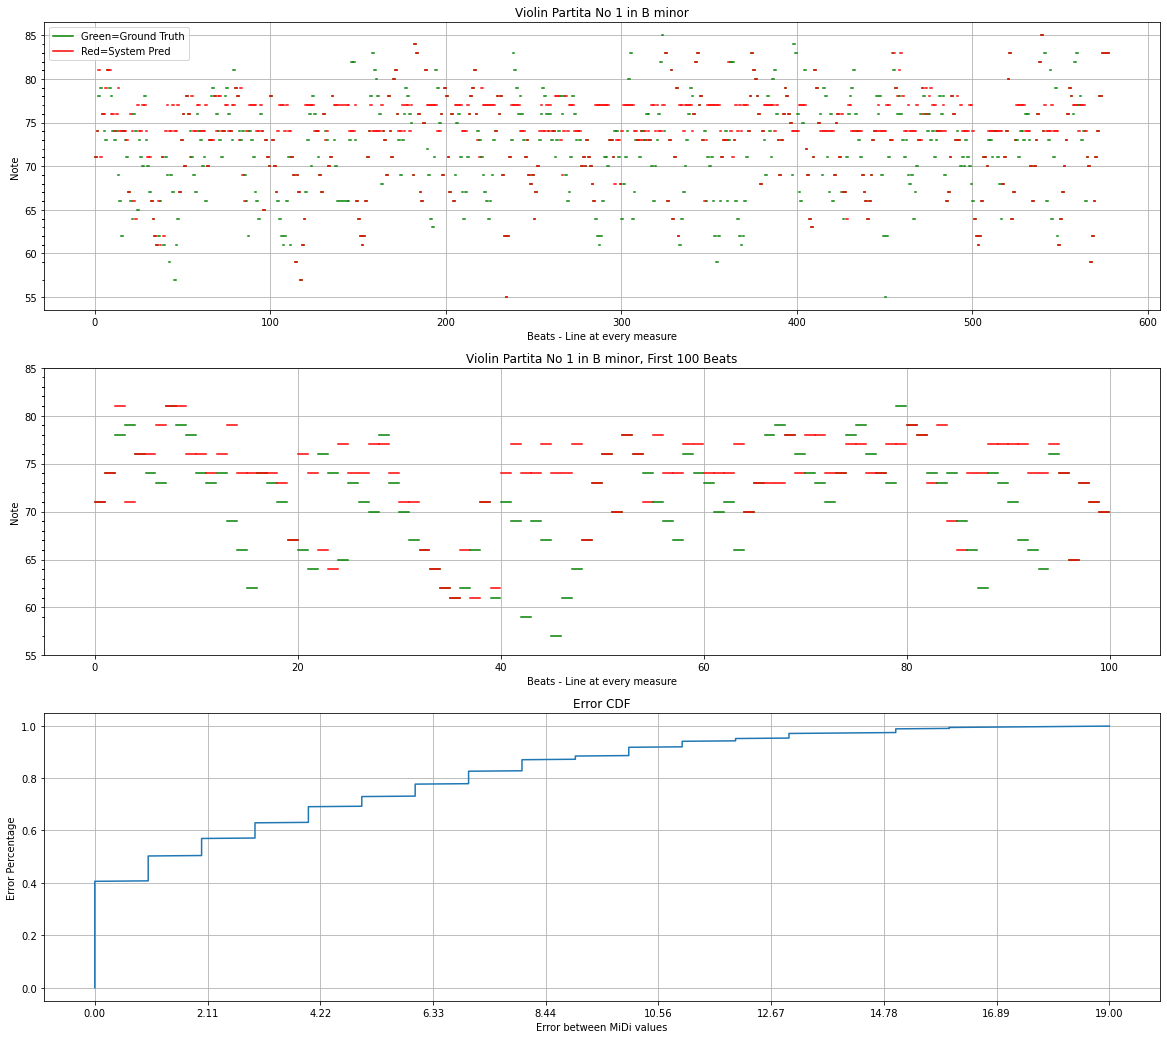

In [242]:
import warnings

# Suppress specific type of warning
warnings.filterwarnings("ignore")

# Performance of System
numPts = len(music_ts)
compressionRate = ((numPts - numPts / rate) / numPts) * 100
error = np.sort(np.array([np.abs(music_ts[i] - musicSeq[i]) for i in range(numPts)]).squeeze())
accuracy = (np.sum([music_ts[i] == musicSeq[i] for i in range(numPts)]) / numPts) * 100
print(f"Compression Rate: {compressionRate:.2f}%, Decompression Accuracy: {accuracy:.3f}%")

fig, axs = plt.subplots(3, 1, figsize=(20, 18)) 
x = musicData['start_beat']
yt = music_ts
yp = musicSeq
    
for i in range(len(x)):
    axs[0].plot([x[i], x[i] + musicData['end_beat'][i]], [yt[i], yt[i]], 'green')
    axs[0].plot([x[i], x[i] + musicData['end_beat'][i]], [yp[i], yp[i]], 'red')

axs[0].set_title(f"{metadata['composition'].values[np.argmax(metadata['id'] == musicId)]}")
axs[0].set_xlabel("Beats - Line at every measure")
axs[0].set_ylabel("Note")
axs[0].set_yticks(yt.squeeze(), [midi_to_note_name(int(i)) for i in yt.squeeze()])
axs[0].grid(True)
axs[0].legend(["Green=Ground Truth", "Red=System Pred"])

for i in range(100):
    axs[1].plot([x[i], x[i] + musicData['end_beat'][i]], [yt[i], yt[i]], 'green')
    axs[1].plot([x[i], x[i] + musicData['end_beat'][i]], [yp[i], yp[i]], 'red')

axs[1].set_title(f"{metadata['composition'].values[np.argmax(metadata['id'] == musicId)]}, First 100 Beats")
axs[1].set_xlabel("Beats - Line at every measure")
axs[1].set_ylabel("Note")
axs[1].set_yticks(yt.squeeze(), [midi_to_note_name(int(i)) for i in yt.squeeze()])
axs[1].grid(True)

axs[2].plot(error, np.arange(numPts) / numPts)
axs[2].set_xticks(np.linspace(min(error), max(error), 10))
axs[2].set_title("Error CDF")
axs[2].set_xlabel("Error between MiDi values")
axs[2].set_ylabel("Error Percentage")
axs[2].grid(True)


In [233]:
print(model)

ConvLSTMModel(
  (softmax): Softmax(dim=None)
  (lstm): LSTM(7, 100, num_layers=3, batch_first=True)
  (fc): Linear(in_features=100, out_features=28, bias=True)
)
